https://github.com/yorkiva/IN/blob/modified_1/03_NeuronFiringDisplay.ipynb

In [1]:
import os 
os.chdir ('/projects/bbhj/asinha15/VLQ-NN-Reweighting/main/')

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import pandas as pd
import torch
import torch.nn as nn
import glob
import json
from DNN.Data import CSVData
from DNN.Data import Data

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
model_path = 'trained_models/[29, 32, 64, 32, 32, 16, 8, 4].pt'
model = torch.jit.load(model_path).to(device)
model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (Linear0): RecursiveScriptModule(original_name=Linear)
  (Activation0): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear1): RecursiveScriptModule(original_name=Linear)
  (Activation1): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear2): RecursiveScriptModule(original_name=Linear)
  (Activation2): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear3): RecursiveScriptModule(original_name=Linear)
  (Activation3): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear4): RecursiveScriptModule(original_name=Linear)
  (Activation4): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear5): RecursiveScriptModule(original_name=Linear)
  (Activation5): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear_last): RecursiveScriptModule(original_name=Linear)
)

In [5]:
for name, param in model.named_parameters():
    print(name)

Linear0.weight
Linear0.bias
Linear1.weight
Linear1.bias
Linear2.weight
Linear2.bias
Linear3.weight
Linear3.bias
Linear4.weight
Linear4.bias
Linear5.weight
Linear5.bias
Linear_last.weight
Linear_last.bias


In [6]:
W = []
B = []
for name, param in model.named_parameters():
    if 'weight' in name:
        W.append(param.cpu().detach().numpy().transpose())
    elif 'bias' in name:
        B.append(param.cpu().detach().numpy())
L = len(W)

In [7]:
def NeuronFiringEvaluator(model, x, weighted_firing=False):
    FiringEvaluator = []
    layer_tags = []
    A = [x] + [None]*L
    for l in range(L-1):
        A[l+1] = np.maximum(0.01*(A[l].dot(W[l])+B[l]),A[l].dot(W[l])+B[l])
        if not weighted_firing:
            FiringEvaluator.append(torch.sum(torch.tensor(A[l+1]) > 0, 0).cpu().numpy())
        else:
            FiringEvaluator.append(torch.sum(torch.tensor(A[l+1]), 0).cpu().numpy())
        layer_tags.append("Linear" + str(l))
    N = A[L-1].dot(W[L-1])+B[L-1]
    del A
    return N, FiringEvaluator, layer_tags

In [8]:
def eval(model, data, mode=[-1,0,1], weighted_firing = False, device = 'cpu'):
    lst = []
    correct = []
    FiringMatrix = []
    ii = 0
    
    with torch.no_grad():
        for X, Y in train_data.generate_data():
            inputs = []
            labels = []
            for i, j in zip(X, np.log(np.array(Y))):
                if i[0] in mode:
                    inputs.append(i)
                    labels.append(i)
            del X, Y
            inputs = np.array(inputs)
            labels = np.array(labels)
            
            out, FiringEvaluator, layer_tags = NeuronFiringEvaluator(model, inputs, weighted_firing)
            if ii == 0:
                for jj in range(len(FiringEvaluator)):
                    FiringMatrix.append(FiringEvaluator[jj])
            else:
                for jj in range(len(FiringEvaluator)):
                    FiringMatrix[jj] += FiringEvaluator[jj]
            lst.append(out)
            correct.append(labels)
            ii += 1
    predicted = np.concatenate(lst)
    f_rwt = np.concatenate(correct)
    
    return predicted, f_rwt, FiringMatrix, layer_tags

In [9]:
def ActivationMapPlotter(FiringMatrix, layer_tags, tag='baseline'):
    FiringMatrix_0 = FiringMatrix.copy()
    N_cols = len(FiringMatrix_0)
    N_rows = max([len(i) for i in FiringMatrix_0])
    
    for ii in range(len(FiringMatrix_0)):
        max_0 = np.amax(FiringMatrix_0[ii])
        FiringMatrix_0[ii] = FiringMatrix_0[ii]/max_0
    for ii in range(N_cols):
        if len(FiringMatrix_0[ii]) < N_rows:
            FiringMatrix_0[ii] = np.append(FiringMatrix_0[ii], 
                                           np.ones(N_rows - len(FiringMatrix_0[ii]))*np.nan)
    
    FiringMatrix_0 = np.array(FiringMatrix_0)

    print("Sparsity measure (RNA < 0.2): ", np.sum(FiringMatrix_0 < 0.2)/FiringMatrix_0.size)
    weights = FiringMatrix_0.reshape(-1) 
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.25
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    
    fig, axes = plt.subplots(1,1,figsize=(6,6))
    norm = colors.TwoSlopeNorm(vcenter=0)
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(0,N_cols+0.25,1), np.arange(N_rows+1)],
                   weights = weights, cmap = 'bwr', cmin = -1, cmax = 1, norm=norm)
    axes.set_facecolor('black')

    fig.colorbar(im, ax=axes)
    axes.set_xlabel('Network Activation Layers')
    axes.set_ylabel('Node in hidden layer')
    axes.set_xticks(np.arange(N_cols) + 0.5) 
    axes.set_xticklabels(layer_tags, rotation='vertical')
    #plt.savefig("plots/XML/NAP_{}.png".format(tag))
    plt.show()

In [25]:
def ActivationMapDifferencePlotter(FiringMatrix_i, FiringMatrix_ii, layer_tags, tag='baseline_difference'):
    FiringMatrix_0 = FiringMatrix_i.copy()
    FiringMatrix_1 = FiringMatrix_ii.copy()
    N_cols = len(FiringMatrix_0)
    N_rows = max([len(i) for i in FiringMatrix_0])
    
    for ii in range(len(FiringMatrix_0)):
        max_0 = FiringMatrix_0[ii].max()
        max_1 = FiringMatrix_1[ii].max()
        FiringMatrix_0[ii] = FiringMatrix_0[ii]/max_0
        FiringMatrix_1[ii] = FiringMatrix_1[ii]/max_1
    for ii in range(N_cols):
        if len(FiringMatrix_0[ii]) < N_rows:
            FiringMatrix_0[ii] = np.append(FiringMatrix_0[ii], 
                                           np.ones(N_rows - len(FiringMatrix_0[ii]))*np.nan)
            FiringMatrix_1[ii] = np.append(FiringMatrix_1[ii], 
                                           np.ones(N_rows - len(FiringMatrix_1[ii]))*np.nan)
    
    FiringMatrix_0 = np.array(FiringMatrix_0)
    FiringMatrix_1 = np.array(FiringMatrix_1)
    
    fig, axes = plt.subplots(1,1,figsize=(6,6))
    weights = np.abs(FiringMatrix_1.reshape(-1) - FiringMatrix_0.reshape(-1))
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.5
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    norm = colors.TwoSlopeNorm(vcenter=0.4)
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(N_cols+1), np.arange(N_rows+1)],
                   weights = weights, cmap = 'Reds', norm=norm)

    fig.colorbar(im, ax=axes)
    axes.set_facecolor('black')
    axes.set_xlabel('Network Activation Layers')
    axes.set_ylabel('Node in hidden layer')
    axes.set_xticks(np.arange(N_cols) + 0.5)
    axes.set_xticklabels(layer_tags, rotation='vertical')

    #plt.savefig("plots_xAI/dNAP_{}.png".format(tag))
    plt.show()
    

In [11]:
features = ['mode',
'Msim',
'Gsim',
'pz_in1',
'pid_in1', 
'pz_in2',
'pid_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'pid_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'pid_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'pid_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'pid_out4',
'Mtarget',
'Gtarget',]
label = 'f_rwt'
features_to_rescale = ['Msim',
'Gsim',
'pz_in1', 
'pz_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'Mtarget',
'Gtarget']

train_data = CSVData(batch_size=1024, features_name=features, labels_name=label, features_to_rescale= features_to_rescale, file_names=['/projects/bbhj/asinha15/train_' + str(i)+'.csv' for i in range(0,10)])

In [12]:
predicted_i, actual_i, FiringMatrix_i, layer_tags_i = eval(model, train_data, mode = [-1], weighted_firing = True)
predicted_ii, actual_ii, FiringMatrix_ii, layer_tags_ii = eval(model, train_data, mode = [0], weighted_firing = True)
predicted_iii, actual_iii, FiringMatrix_iii, layer_tags_iii = eval(model, train_data, mode = [1], weighted_firing = True)

Mode W
Sparsity measure (RNA < 0.2):  0.2708333333333333


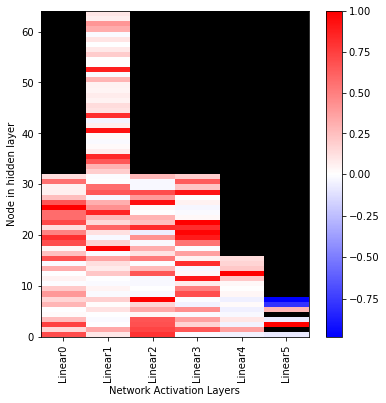

In [13]:
print("Mode W")
ActivationMapPlotter(FiringMatrix_i, layer_tags_i)

Mode H
Sparsity measure (RNA < 0.2):  0.3541666666666667


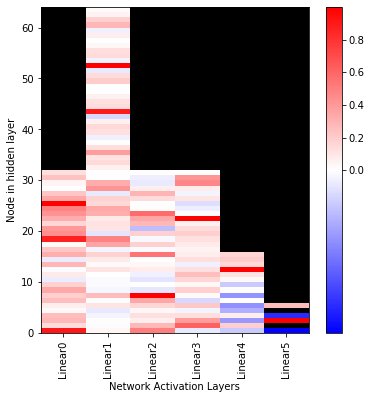

In [14]:
print("Mode H")
ActivationMapPlotter(FiringMatrix_ii, layer_tags_ii)

Mode Z
Sparsity measure (RNA < 0.2):  0.2734375


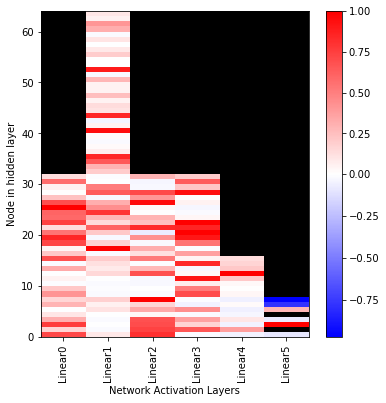

In [15]:
print("Mode Z")
ActivationMapPlotter(FiringMatrix_iii, layer_tags_iii)

W-H


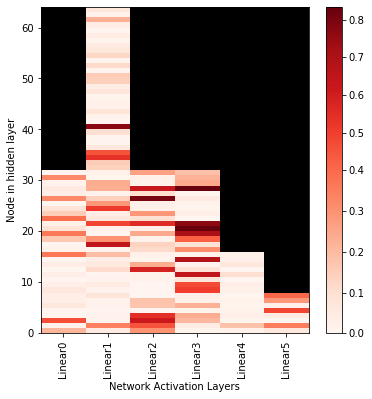

In [26]:
 print("W-H")
ActivationMapDifferencePlotter(FiringMatrix_i, FiringMatrix_ii, layer_tags_i)

W-Z


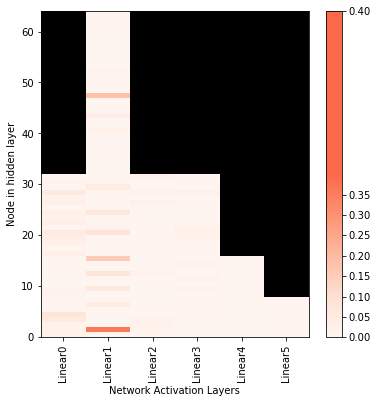

In [27]:
 print("W-Z")
ActivationMapDifferencePlotter(FiringMatrix_i, FiringMatrix_iii, layer_tags_i)